In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.2.2


In [48]:
xshift, yshift = np.load("test/ERS_jwst/NIRSpec/find_shifts.npy")

In [38]:
from astropy.io import fits
with fits.open("test/ERS_jwst/NIRSpec/jwdata0010010_11010_0001_NRS1_uncal_updatedHDR_MOD_injected_x1dints.fits") as hdu:
    print(hdu[2].header)
    print(hdu[2].data)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  140 / length of dimension 1                          NAXIS2  =                  432 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   18 / number of table fields                         EXTNAME = 'EXTRACT1D'          / extension name                                 EXTVER  =                    1 / extension value                                TTYPE1  = 'WAVELENGTH'                                                          TFORM1  = 'D       '                                                            TUNIT1  = 'um      '                    

[(0.5527795 ,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.55617201,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.55962831,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.56315398,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.56673986,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.57038981,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.57411301,             nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0., 0., 0., 0., 0., 0.,           0, 0., 0., 0., 0., 0., 0.)
 (0.57790977,       

In [50]:
# load Eureka! rainbow:
# r_eureka = Rainbow("test/ERS_eureka/S3_nircam_wfss_template_ap8_bg16_Table_Save.txt")
# load jwst rainbow:
r_jwst = Rainbow("test/ERS_jwst/NIRSpec/*x1dints.fits")


🌈 Warning: No times found! Making up imaginary ones!
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.24s/it]


In [51]:
binwave = 0.2
bintime = 5./60
# r_eureka_binned = r_eureka.normalize().bin(dw=binwave * u.micron, dt=bintime * u.hour)
# r_jwst.fluxlike['uncertainty'] = r_jwst.fluxlike['flux_error']
rb = r_jwst.normalize().bin(dw=binwave * u.micron, dt=bintime * u.hour)

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='Wavelength ($\\mathrm{\\mu m}$)'>

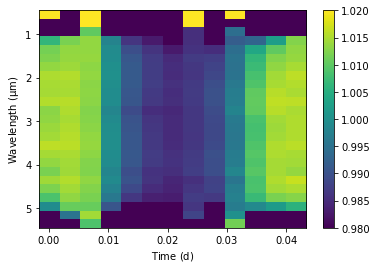

In [68]:
rb.imshow(vmax=1.02,vmin=0.98)

In [54]:
r_jwst.fluxlike['x'] = xshift
r_jwst.fluxlike['y'] = yshift

In [70]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(period = Fitted(Uniform, testval=3),
#     period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                   epoch=Fitted(Uniform,lower=0.01,upper=0.03),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

In [71]:
cm = t * (b + b_x + b_y + b_bkg)

In [73]:
cm.attach_data(rb)
cm.setup_lightcurves()
cm.setup_likelihood()
opt = cm.optimize()
cm.sample(start=opt, tune=4000, draws=4000, cores=4, chains=4)
cm.summarize(round_to=7, fmt='wide')

unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 242165.36it/s]
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNIN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNIN

message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: El

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=[2], acc_dtype=float64}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Sum{axis=

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNIN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNIN

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_in

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'stime_p_1': array(0.), 'sbkg_p_1': array(0.), 'transit_period_interval__': array(nan), 'transit_epoch_interval__': array(8.8817842e-16), 'transit_impact_parameter_impact__': array(-0.47849024), 'transit_stellar_radius_interval__': array(0.), 'transit_stellar_mass_interval__': array(0.), 'transit_limb_darkening_quadlimbdark__': array([-1.65822808, -2.7080502 ]), 'transit_radius_ratio_w0': array(0.5), 'transit_baseline_interval__': array(0.), 'transit_radius_ratio_w1': array(0.5), 'transit_radius_ratio_w2': array(0.5), 'transit_radius_ratio_w3': array(0.5), 'transit_radius_ratio_w4': array(0.5), 'transit_radius_ratio_w5': array(0.5), 'transit_radius_ratio_w6': array(0.5), 'transit_radius_ratio_w7': array(0.5), 'transit_radius_ratio_w8': array(0.5), 'transit_radius_ratio_w9': array(0.5), 'transit_radius_ratio_w10': array(0.5), 'transit_radius_ratio_w11': array(0.5), 'transit_radius_ratio_w12': array(0.5), 'transit_radius_ratio_w13': array(0.5), 'transit_radius_ratio_w14': array(0.5), 'transit_radius_ratio_w15': array(0.5), 'transit_radius_ratio_w16': array(0.5), 'transit_radius_ratio_w17': array(0.5), 'transit_radius_ratio_w18': array(0.5), 'transit_radius_ratio_w19': array(0.5), 'transit_radius_ratio_w20': array(0.5), 'transit_radius_ratio_w21': array(0.5), 'transit_radius_ratio_w22': array(0.5), 'transit_radius_ratio_w23': array(0.5), 'transit_radius_ratio_w24': array(0.5), 'transit_period': array(nan), 'transit_epoch': array(0.02), 'transit_impact_parameter': array(0.44), 'transit_stellar_radius': array(1.), 'transit_stellar_mass': array(1.), 'transit_limb_darkening': array([0.05, 0.35]), 'transit_baseline': array(1.)}

Initial evaluation results:
stime_p_1                                      3.69
sbkg_p_1                                       3.69
transit_period_interval__                       NaN
transit_epoch_interval__                      -1.39
transit_impact_parameter_impact__             -1.44
transit_stellar_radius_interval__             -1.39
transit_stellar_mass_interval__               -1.39
transit_limb_darkening_quadlimbdark__         -4.84
transit_radius_ratio_w0                        2.08
transit_baseline_interval__                   -1.39
transit_radius_ratio_w1                        2.08
transit_radius_ratio_w2                        2.08
transit_radius_ratio_w3                        2.08
transit_radius_ratio_w4                        2.08
transit_radius_ratio_w5                        2.08
transit_radius_ratio_w6                        2.08
transit_radius_ratio_w7                        2.08
transit_radius_ratio_w8                        2.08
transit_radius_ratio_w9                        2.08
transit_radius_ratio_w10                       2.08
transit_radius_ratio_w11                       2.08
transit_radius_ratio_w12                       2.08
transit_radius_ratio_w13                       2.08
transit_radius_ratio_w14                       2.08
transit_radius_ratio_w15                       2.08
transit_radius_ratio_w16                       2.08
transit_radius_ratio_w17                       2.08
transit_radius_ratio_w18                       2.08
transit_radius_ratio_w19                       2.08
transit_radius_ratio_w20                       2.08
transit_radius_ratio_w21                       2.08
transit_radius_ratio_w22                       2.08
transit_radius_ratio_w23                       2.08
transit_radius_ratio_w24                       2.08
wavelength_0_data                         -65688.95
wavelength_1_data                        -180178.03
wavelength_2_data                         -53925.74
wavelength_3_data                        -129654.60
wavelength_4_data                        -350702.75
wavelength_5_data                        -646784.26
wavelength_6_data                       -1133163.76
wavelength_7_data                       -1968523.00
wavelength_8_data                       -2864503.65
wavelength_9_data                       -3871138.06
wavelength_10_data                      -4585577.15
wavelength_11_data                      -2510018.46
wavelength_12_data                      -1888510.77
wavelength_13_data                      -2212172.26
wavelength_14_data                      -2813095.15
wavelength_15_data                      -4027642.06
wavelength_16_data                      -5008829.93
wavelength_17_data                      -4122659.40
wavelength_18_data                      -2499831.31
wavelength_19_data                      -2971984.59
wavelength_20_data                      -2009391.00
wavelength_21_data                       -862148.34
wavelength_22_data                       -271104.72
wavelength_23_data                       -147054.95
wavelength_24_data                        -50223.43
Name: Log-probability of test_point, dtype: float64